# Import the essentials

In [ ]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

# Mount Google Drive if you're working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Update base directory to point to Google Drive
base_dir = "/content/drive/My Drive/DiabeticRetinopathy"


Mounted at /content/drive


# Loading Data + EDA

In [ ]:
# Update the paths to point to Google Drive
train_csv = pd.read_csv('/content/drive/My Drive/DiabeticRetinopathy/train.csv')
test_csv = pd.read_csv('/content/drive/My Drive/DiabeticRetinopathy/test.csv')


In [ ]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 501


In [ ]:
train_csv.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

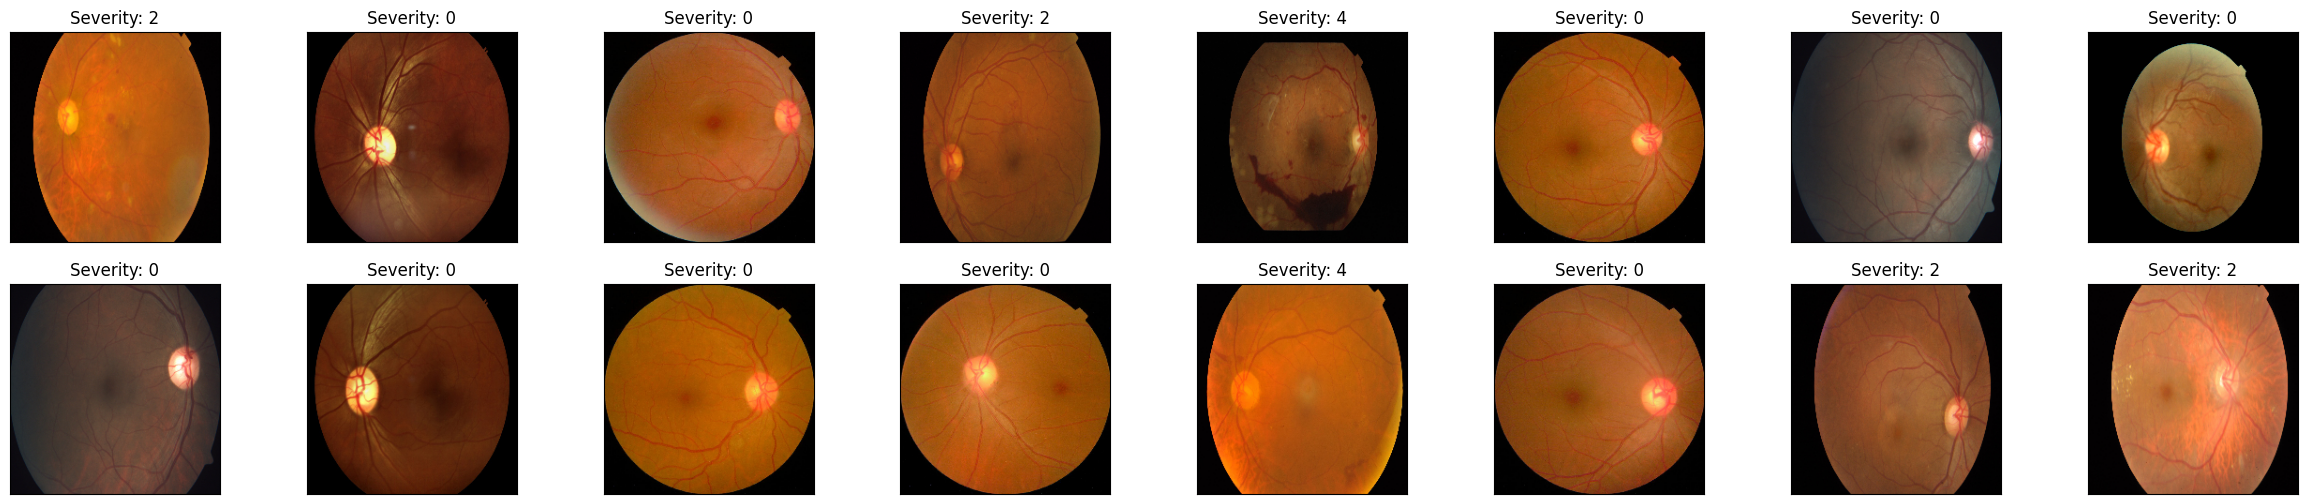

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd

# Assuming train_csv is already loaded from Google Drive
train_csv = pd.read_csv('/content/drive/My Drive/DiabeticRetinopathy/train.csv')

# Plot images from the updated Google Drive path
fig = plt.figure(figsize=(30, 6))

# Display 16 images from the training dataset
train_imgs = os.listdir(base_dir + "/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16 // 2, idx + 1, xticks=[], yticks=[])
    im = Image.open(base_dir + "/train_images/" + img)
    plt.imshow(im)

    # Fetch the severity label from the CSV file
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title(f'Severity: {lab}')


# Visualizing Training Data

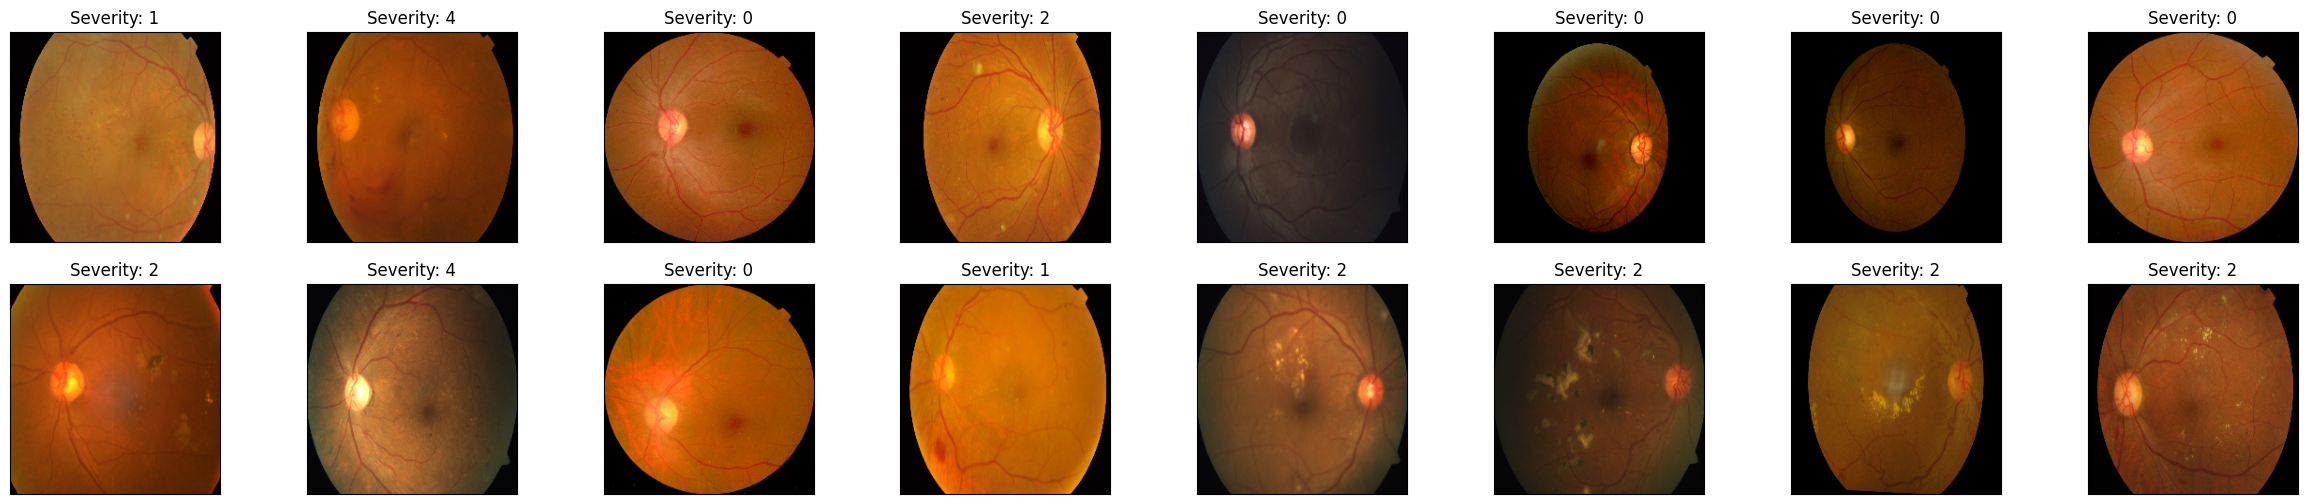

In [ ]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

# Visualizing Test Set

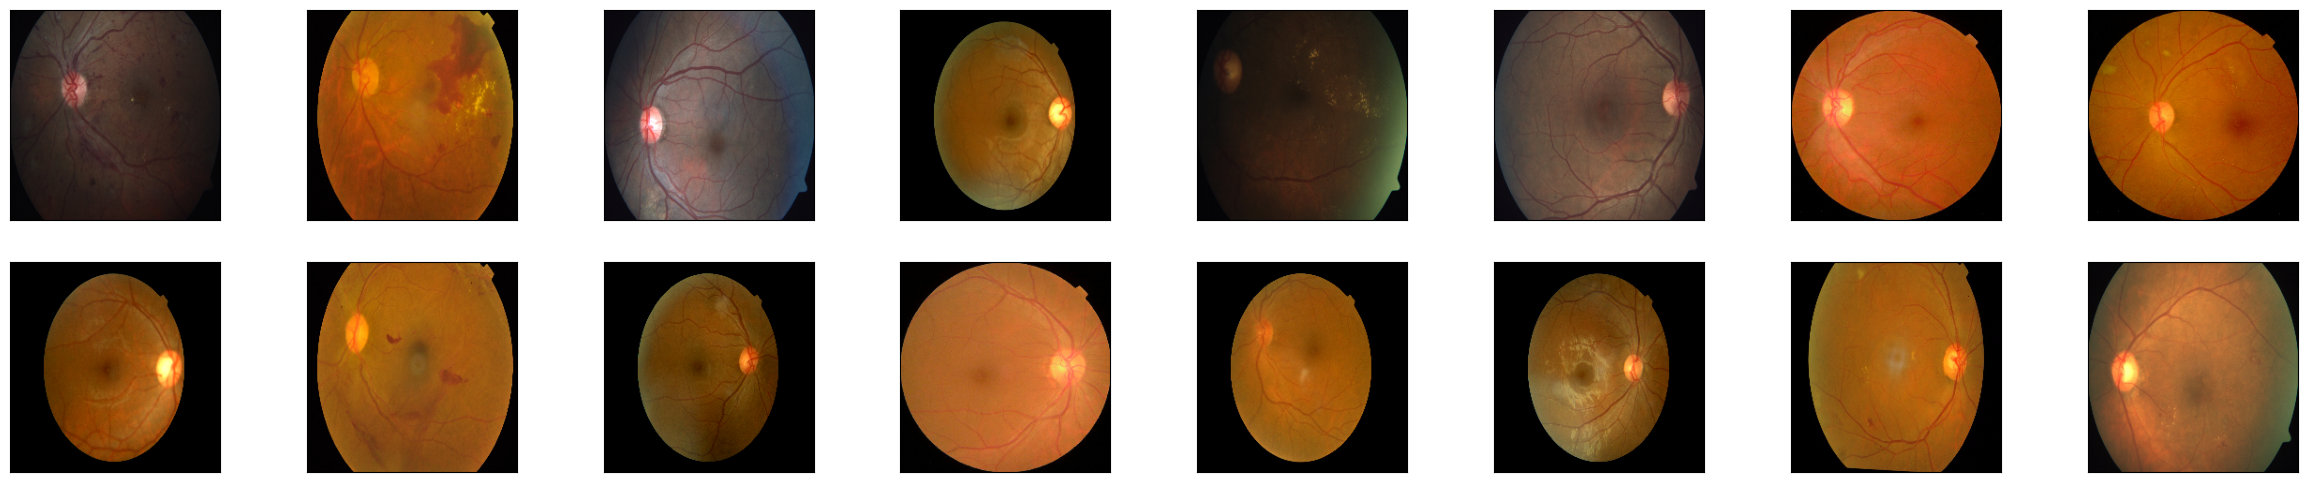

In [ ]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

# Data Processing

In [ ]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
# Update the paths to point to your Google Drive location
train_path = "/content/drive/My Drive/DiabeticRetinopathy/train_images/"
test_path = "/content/drive/My Drive/DiabeticRetinopathy/test_images/"

In [ ]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)


In [ ]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [ ]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 3662
testing examples contain : 501
46
12
8


In [ ]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([0, 2, 0, 3, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 1, 4, 0, 0, 2, 0, 0, 3, 4, 0,
        0, 0, 4, 0, 2, 0, 0, 1, 2, 1, 0, 2, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 1, 4,
        0, 0, 0, 0, 1, 2, 4, 2, 2, 2, 0, 4, 2, 1, 0, 2])


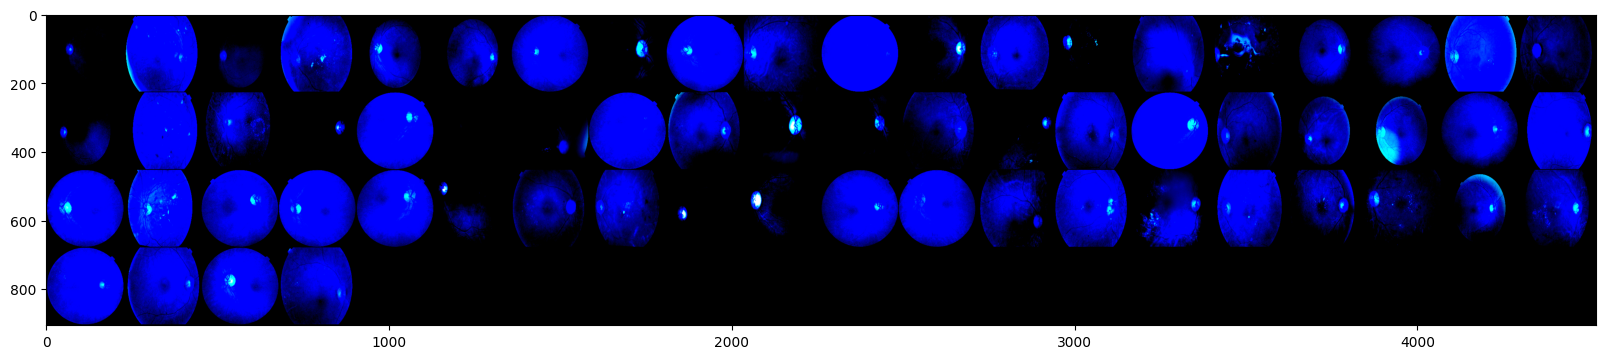

In [ ]:
# plotting the images of loaded batch with given fig size and frame data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print('labels:', labels)

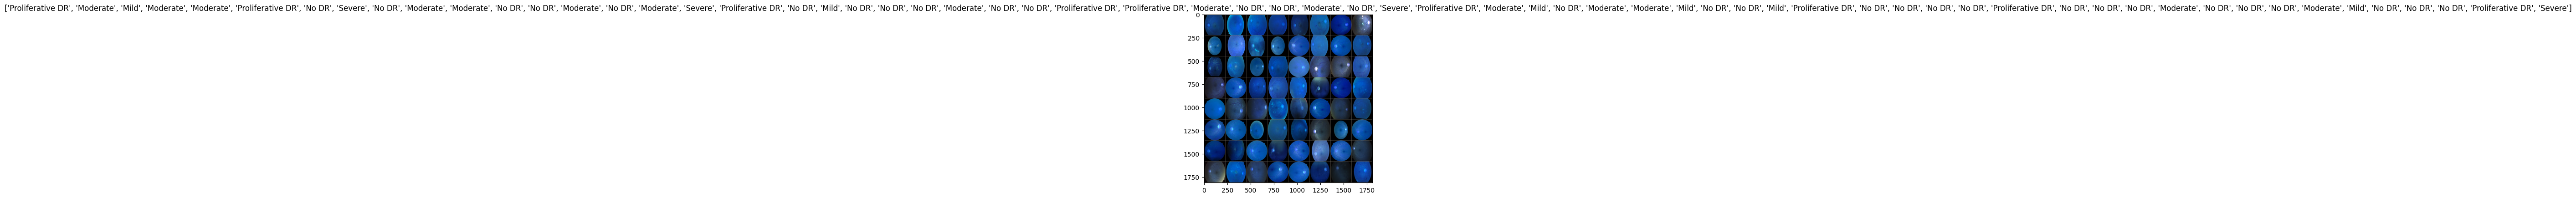

In [ ]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [ ]:
# Install the latest version of PyTorch with CUDA 11.7 (for example)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://download.pytorch.org/whl/cu117


In [ ]:
# Example: Move model and data to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a sample model and move it to the device (GPU if available)
model = torchvision.models.resnet18().to(device)

# Example tensor and move it to CUDA
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = model(sample_input)

print(f"Output device: {output.device}")


Output device: cuda:0


In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

num_ftrs = model.fc.in_features
out_ftrs = 5

model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 54.6MB/s]


In [ ]:
# to unfreeze more layers
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_model(model, optimizer, device=torch.device('cpu')):
    # Path to the model in Google Drive
    path = "/content/drive/My Drive/DiabeticRetinopathy/classifier.pt"

    # Load the checkpoint
    checkpoint = torch.load(path, map_location=device)

    # Load model and optimizer state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Set the model to the correct device
    model.to(device)

    return model, optimizer


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [ ]:
def train_and_test(train_data, valid_data, e=5, batch_size=64):  # Add train_data, valid_data as parameters
    epochs = e

    # DataLoaders for training and validation
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

    train_losses, test_losses, acc = [], [], []
    valid_loss_min = np.Inf
    model.train()
    print("Model Training started.....")

    for epoch in range(epochs):
        running_loss = 0
        batch = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch += 1

            if batch % 10 == 0:
                print(f"epoch {epoch + 1}, batch {batch} completed")

        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            print(f"Validation started for epoch {epoch + 1}")
            model.eval()

            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(validloader))
        acc.append(accuracy)

        scheduler.step()

        print(f"Epoch: {epoch + 1}/{epochs}.. "
              f"Training Loss: {running_loss / len(trainloader):.3f}.. "
              f"Valid Loss: {test_loss / len(validloader):.3f}.. "
              f"Valid Accuracy: {accuracy / len(validloader):.3f}")

        model.train()

        if test_loss / len(validloader) <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {test_loss / len(validloader):.6f}). Saving model ...')
            torch.save({
                'epoch': epoch,
                'model': model,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': valid_loss_min
            }, path)
            valid_loss_min = test_loss / len(validloader)

    print('Training Completed Successfully!')
    return train_losses, test_losses, acc


In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
image_dir="/content/drive/My Drive/DiabeticRetinopathy/train_images"
class CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None, image_dir=None):
        # Load CSV file
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.image_dir = image_dir  # Directory where the images are located

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image filename and label from the CSV file
        img_name = self.data.iloc[idx, 0]  # id_code column
        if self.image_dir:
            img_name = os.path.join(self.image_dir, img_name + ".png")  # Prepend the image directory and add .png extension
        label = int(self.data.iloc[idx, 1])  # diagnosis column (class label)

        # Open the image
        try:
            image = Image.open(img_name)
        except FileNotFoundError:
            print(f"Image not found: {img_name}")
            # Handle missing image, here we return a black image
            image = Image.new('RGB', (64, 64), (0, 0, 0))

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Paths to the image directory and CSV files
image_dir="/content/drive/My Drive/DiabeticRetinopathy/train_images"# Change to the correct path where your images are stored
train_csv = '/content/drive/My Drive/DiabeticRetinopathy/train.csv'  # Path to your train CSV
test_csv = '/content/drive/My Drive/DiabeticRetinopathy/test.csv'    # Path to your test CSV

# Define transformation (resize to 64x64 and convert to tensor)
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Load train and test datasets using the CSVDataset class
train_data = CSVDataset(csv_file=train_csv, transform=transform, image_dir=image_dir)
test_data = CSVDataset(csv_file=test_csv, transform=transform, image_dir=image_dir)

# Create DataLoader for train and test data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Adjust dimensions based on input size
        self.fc2 = nn.Linear(128, 5)  # 5 classes: 0, 1, 2, 3, 4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 32 * 32)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNModel().to(device)


In [ ]:
# Save the model to the Colab directory
torch.save(model.state_dict(), '/content/drive/My Drive/DiabeticRetinopathy/cnn_model.pth')
from google.colab import files




In [ ]:
import torch.optim as optim

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Multi-class classification

# Training and validation function
def train_and_validate(model, train_loader, test_loader, epochs=5):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update weights

            running_loss += loss.item()



            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print training statistics
        print(f"Epoch {epoch+1}/{epochs}.. Loss: {running_loss/len(train_loader):.4f}.. Accuracy: {100 * correct / total:.2f}%")

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Print validation statistics
        print(f"Validation Loss: {val_loss/len(test_loader):.4f}.. Validation Accuracy: {100 * correct / total:.2f}%")

# Start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_and_validate(model, train_loader, test_loader, epochs=5)



Epoch 1/5.. Loss: 0.9113.. Accuracy: 67.18%
Validation Loss: 0.7445.. Validation Accuracy: 73.05%
Epoch 2/5.. Loss: 0.7778.. Accuracy: 72.23%
Validation Loss: 0.7125.. Validation Accuracy: 72.46%
Epoch 3/5.. Loss: 0.7242.. Accuracy: 73.16%
Validation Loss: 0.7054.. Validation Accuracy: 75.45%
Epoch 4/5.. Loss: 0.7055.. Accuracy: 73.98%
Validation Loss: 0.6559.. Validation Accuracy: 76.05%
Epoch 5/5.. Loss: 0.6736.. Accuracy: 74.93%
Validation Loss: 0.6473.. Validation Accuracy: 75.65%


In [ ]:
# Path where you want to save the model in Google Drive
model_save_path = '/content/drive/My Drive/DiabeticRetinopathy/model.pth'

# Save the trained model's state_dict
torch.save(model.state_dict(), model_save_path)

print(f'Model saved to {model_save_path}')


Model saved to /content/drive/My Drive/DiabeticRetinopathy/model.pth


Epoch 1/5.. Loss: 1.0530.. Accuracy: 64.55%
Validation Loss: 0.7799.. Validation Accuracy: 72.65%


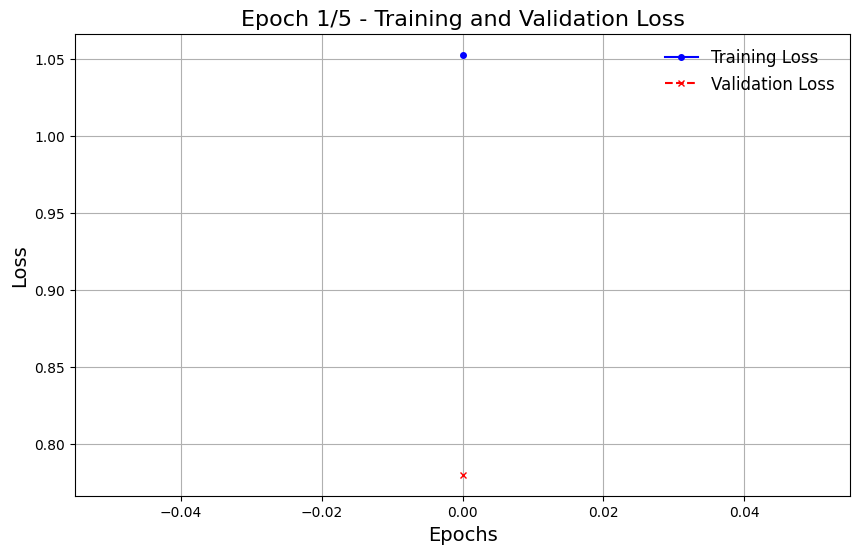

Epoch 2/5.. Loss: 0.7792.. Accuracy: 71.44%
Validation Loss: 0.7703.. Validation Accuracy: 72.26%


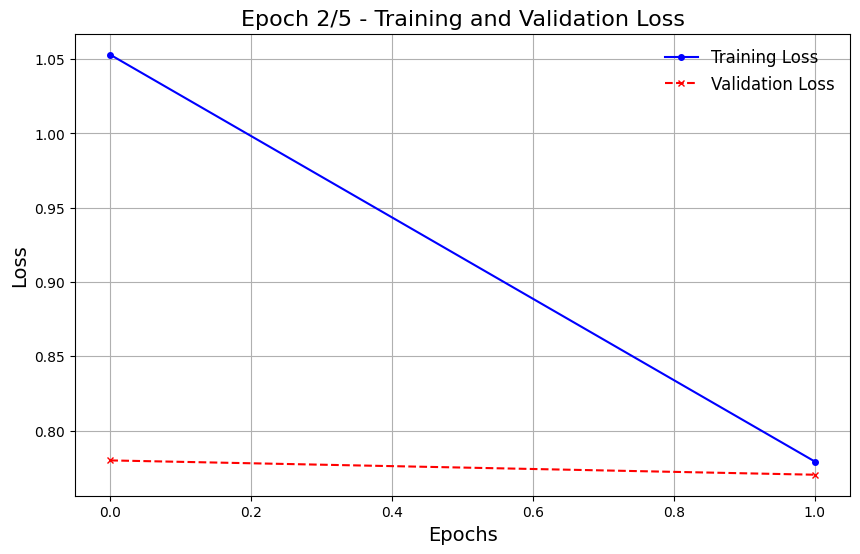

Epoch 3/5.. Loss: 0.7423.. Accuracy: 72.77%
Validation Loss: 0.6819.. Validation Accuracy: 75.25%


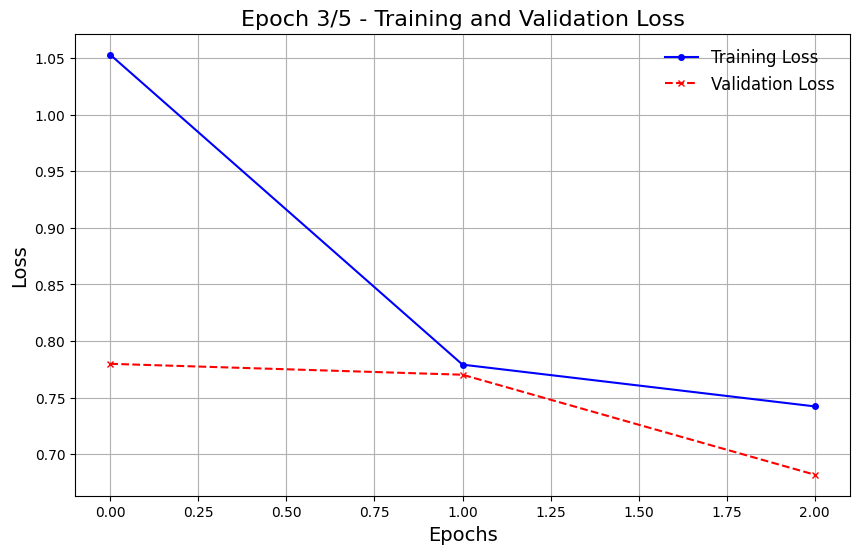

Epoch 4/5.. Loss: 0.7216.. Accuracy: 73.29%
Validation Loss: 0.6803.. Validation Accuracy: 73.85%


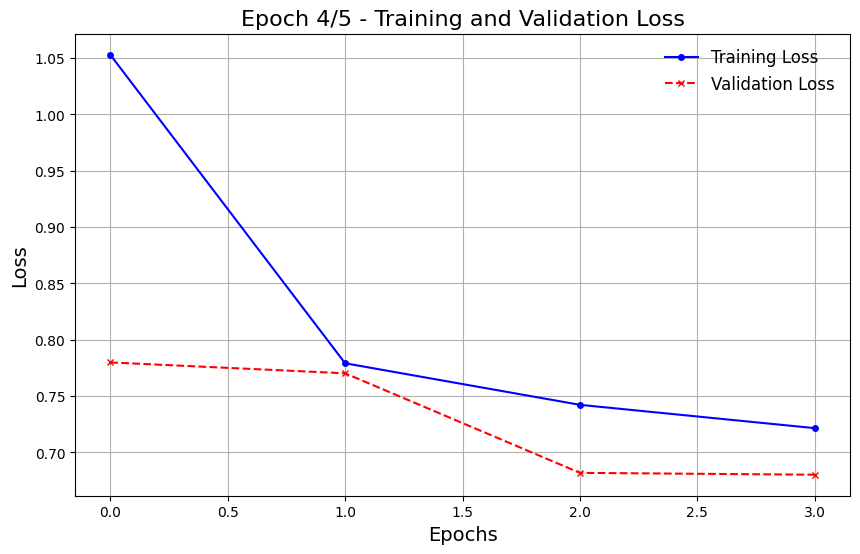

Epoch 5/5.. Loss: 0.7004.. Accuracy: 73.98%
Validation Loss: 0.6565.. Validation Accuracy: 74.85%


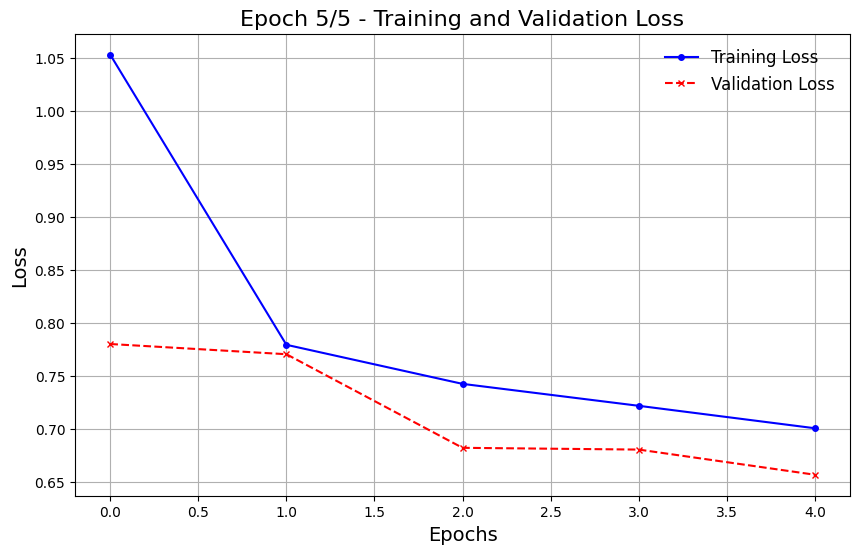

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store the training and validation losses
train_losses = []
valid_losses = []

def train_and_validate(model, train_loader, test_loader, epochs=5):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update weights

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate and store the training loss
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Print training statistics
        print(f"Epoch {epoch+1}/{epochs}.. Loss: {epoch_train_loss:.4f}.. Accuracy: {100 * correct / total:.2f}%")

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate and store the validation loss
        epoch_val_loss = val_loss / len(test_loader)
        valid_losses.append(epoch_val_loss)

        # Print validation statistics
        print(f"Validation Loss: {epoch_val_loss:.4f}.. Validation Accuracy: {100 * correct / total:.2f}%")

        # Plot the training and validation losses after each epoch
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss', color='blue', marker='o', linestyle='-', markersize=4)
        plt.plot(valid_losses, label='Validation Loss', color='red', marker='x', linestyle='--', markersize=4)

        # Add labels, legend, and title
        plt.title(f'Epoch {epoch+1}/{epochs} - Training and Validation Loss', fontsize=16)
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.legend(loc='upper right', frameon=False, fontsize=12)

        # Add gridlines for better readability
        plt.grid(True)

        # Show the plot after validation
        plt.show()

# Initialize your model, criterion, optimizer, and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Multi-class classification

# Start training and validation
train_and_validate(model, train_loader, test_loader, epochs=5)


In [ ]:
!pip install flask pyngrok


In [ ]:
%cd /content/drive/MyDrive/DiabeticRetinopathy/


/content/drive/MyDrive/DiabeticRetinopathy


Saving 0abf0c485f66.png to 0abf0c485f66.png
User uploaded file "0abf0c485f66.png" with length 41157 bytes


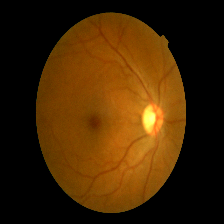

In [ ]:
from google.colab import files
from PIL import Image

# Upload image file
uploaded = files.upload()

# Load the uploaded image and display it
for fn in uploaded:
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    image = Image.open(fn)
    display(image)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# Load the trained model (assuming it has been defined earlier in your notebook)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Adjust dimensions based on input size
        self.fc2 = nn.Linear(128, 5)  # 5 classes: 0, 1, 2, 3, 4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 32 * 32)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the saved model
model = CNNModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/DiabeticRetinopathy/model.pth', map_location=torch.device('cpu')))
model.eval()

# Define the class labels
class_labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Preprocessing function
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize the image to match input size of the model
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Run inference
image_tensor = preprocess_image(image)
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    label = class_labels[predicted.item()]

# Display the prediction
print(f'Prediction: {label}')

# Define the class labels
class_labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']





Prediction: No DR


<ipython-input-81-2dc8cab0348b>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/DiabeticRetinopathy/model.pth', ma

In [ ]:
from IPython.display import display, HTML

# Display the prediction in HTML
result_html = f"""
<div class="result">
    <h2>Prediction: {label}</h2>
</div>
"""
display(HTML(result_html))
